# Classifiez automatiquement des biens de consommation
# Dataset preprocessing & feature extraction

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

# Imports

In [2]:
import sys
import time
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

# TEXT - Preprocessing
import nltk
nltk.download("all")
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

# Models
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

# Bert
import transformers
from transformers import TFAutoModel, AutoTokenizer

# IMAGES
from PIL import Image
import cv2

# CNN
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    | 

[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package mte_teip5 to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package mte_teip5 is already up-to-date!
[nltk_data]    | Downloading package mwa_ppdb to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package mwa_ppdb is already up-to-date!
[nltk_data]    | Downloading package names to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Downloading package nombank.1.0 to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package nombank.1.0 is already up-to-date!
[nltk_data]    | Downloading package nonbreaking_prefixes to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package nonbreaking_prefixes is already up-to-date!
[nltk_data]    | Downloading package nps_chat

[nltk_data]    |   Package universal_treebanks_v20 is already up-to-
[nltk_data]    |       date!
[nltk_data]    | Downloading package vader_lexicon to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package vader_lexicon is already up-to-date!
[nltk_data]    | Downloading package verbnet to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package verbnet is already up-to-date!
[nltk_data]    | Downloading package verbnet3 to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package verbnet3 is already up-to-date!
[nltk_data]    | Downloading package webtext to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package webtext is already up-to-date!
[nltk_data]    | Downloading package wmt15_eval to
[nltk_data]    |     C:\Users\octav\AppData\Roaming\nltk_data...
[nltk_data]    |   Package wmt15_eval is already up-to-date!
[nltk_data]    | Downloadin

In [3]:
file_path = 'Flipkart/flipkart_com-ecommerce_sample_1050.csv'
data = pd.read_csv(file_path)
data.shape

(1050, 15)

# DESCRIPTION - Exploration

In [4]:
data.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...

In [5]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [6]:
data.duplicated(subset=['uniq_id', 'product_url']).sum()

0

In [7]:
data.duplicated(subset=['image']).sum()

0

In [8]:
data.duplicated(subset=['description']).sum()

0

In [9]:
len(data['product_category_tree'].unique())

642

In [10]:
data.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [11]:
data.describe(include='all')

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000   
freq                                   1                        150   
mean                                 NaN                        NaN   
std                                  NaN                        NaN   
min                                  NaN                        NaN   
25%                                  NaN                        NaN   
50%                                  NaN                        NaN   
75%                                  NaN                        NaN   
max                                  NaN                        NaN   

                                              product_url  \
count                                                1050   
unique                                               1050   
top     http://www.flipkart.com/elegance-polyester-mul...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                             product_name  \
count                                                1050   
unique                                               1050   
top     Elegance Polyester Multicolor Abstract Eyelet ...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                    product_category_tree               pid  \
count                                                1050              1050   
unique                                                642              1050   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  CRNEG7BKMFFYHQ8Z   
freq                                                   56                 1   
mean                                                  NaN               NaN   
std                                                   NaN               NaN   
min                                                   NaN               NaN   
25%                                                   NaN               NaN   
50%                                                   NaN               NaN   
75%                                                   NaN               NaN   
max                                                   NaN               NaN   

         retail_price  discounted_price                                 image  \
count     1049.000000       1049.000000                                  1050   
unique            NaN               NaN                                  1050   
top               NaN               NaN  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq              NaN               NaN                                     1   
mean      2186.197331       1584.527169                                   NaN   
std       7639.229411       7475.099680                                   NaN   
min         35.000000         35.000000                                   NaN   
25%        555.000000        340.000000                                   NaN   
50%        999.000000        600.000

<Axes: xlabel='description', ylabel='Count'>

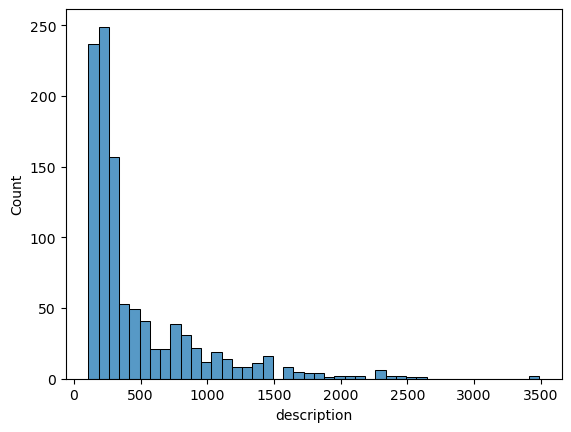

In [12]:
sns.histplot(data['description'].str.len())

## First cleaning : Splitting categories

In [13]:
data_to_drop = ['crawl_timestamp',
                'product_url',
                'pid',
                'retail_price',
                'discounted_price',
                'is_FK_Advantage_product',
                'product_rating',
                'overall_rating',
                'brand',
                'product_specifications']
data.drop(columns=data_to_drop, inplace=True)

In [14]:
data.head(2)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...

In [15]:
data['product_category_tree'][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [16]:
def categories_splitter(categ):
    """ Clean and split a series of categories.
    Return a dataframe with each level of categories in columns"""
    df = pd.DataFrame(columns=['cat1',
                               'cat2',
                               'cat3',
                               'cat4',
                               'cat5',
                               'cat6',
                               'cat7'])

    for categorie in categ:
        my_string = categorie.replace(' >> ', '" , "')
        my_list = eval(my_string)
        clean_categ = pd.DataFrame([my_list],
                                   columns=df.columns[:len(my_list)])
        df = pd.concat([df, clean_categ], axis=0, ignore_index=True)

    return df

In [17]:
categ_df = categories_splitter(data['product_category_tree'])

categ_df.head()

cat1                    cat2              cat3  \
0  Home Furnishing  Curtains & Accessories          Curtains   
1        Baby Care        Baby Bath & Skin  Baby Bath Towels   
2        Baby Care        Baby Bath & Skin  Baby Bath Towels   
3  Home Furnishing               Bed Linen         Bedsheets   
4  Home Furnishing               Bed Linen         Bedsheets   

                                                cat4  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                          Sathiyas Baby Bath Towels   
2                           Eurospa Baby Bath Towels   
3                    SANTOSH ROYAL FASHION Bedsheets   
4                             Jaipur Print Bedsheets   

                                                cat5 cat6 cat7  
0                                                NaN  NaN  NaN  
1  Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...  NaN  NaN  
2  Eurospa Cotton Terry Face Towel Set (20 PIECE ...  NaN  NaN  
3  SANTOSH ROYAL FASHION Cotton Printed King size...  NaN  NaN  
4  Jaipur Print Cotton Floral King sized Double B...  NaN  NaN

In [18]:
categ_df.head()

cat1                    cat2              cat3  \
0  Home Furnishing  Curtains & Accessories          Curtains   
1        Baby Care        Baby Bath & Skin  Baby Bath Towels   
2        Baby Care        Baby Bath & Skin  Baby Bath Towels   
3  Home Furnishing               Bed Linen         Bedsheets   
4  Home Furnishing               Bed Linen         Bedsheets   

                                                cat4  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                          Sathiyas Baby Bath Towels   
2                           Eurospa Baby Bath Towels   
3                    SANTOSH ROYAL FASHION Bedsheets   
4                             Jaipur Print Bedsheets   

                                                cat5 cat6 cat7  
0                                                NaN  NaN  NaN  
1  Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...  NaN  NaN  
2  Eurospa Cotton Terry Face Towel Set (20 PIECE ...  NaN  NaN  
3  SANTOSH ROYAL FASHION Cotton Printed King size...  NaN  NaN  
4  Jaipur Print Cotton Floral King sized Double B...  NaN  NaN

In [19]:
categ_df.shape

(1050, 7)

Text(0.5, 1.0, 'Distribution of the 7th first categories')

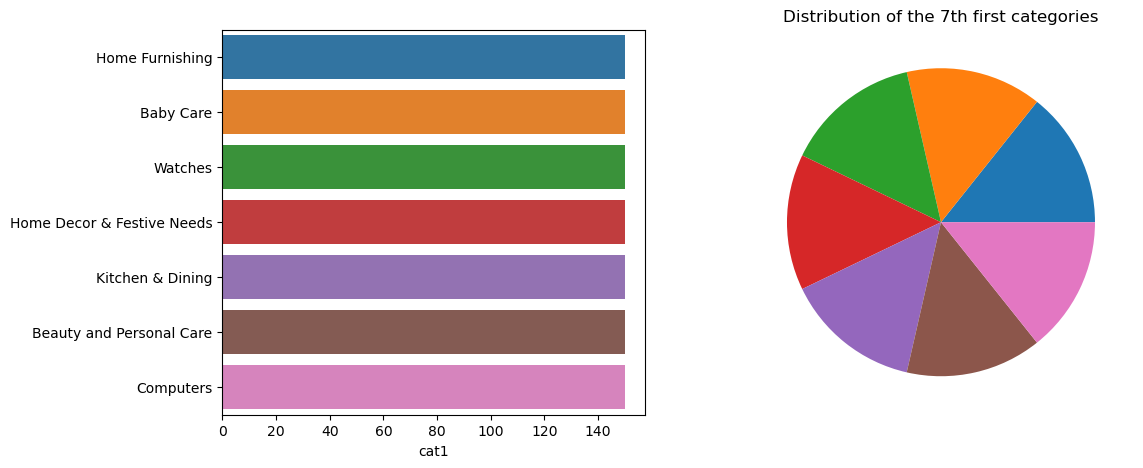

In [20]:
labels = categ_df['cat1'].value_counts().sort_values(ascending=False).index
count = categ_df['cat1'].value_counts().sort_values(ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[1].pie(count)
sns.barplot(x=count, y=labels, ax=axs[0])
plt.title('Distribution of the ' + str(len(labels)) + 'th first categories')

Text(0.5, 1.0, 'Distribution of the 62th second categories')

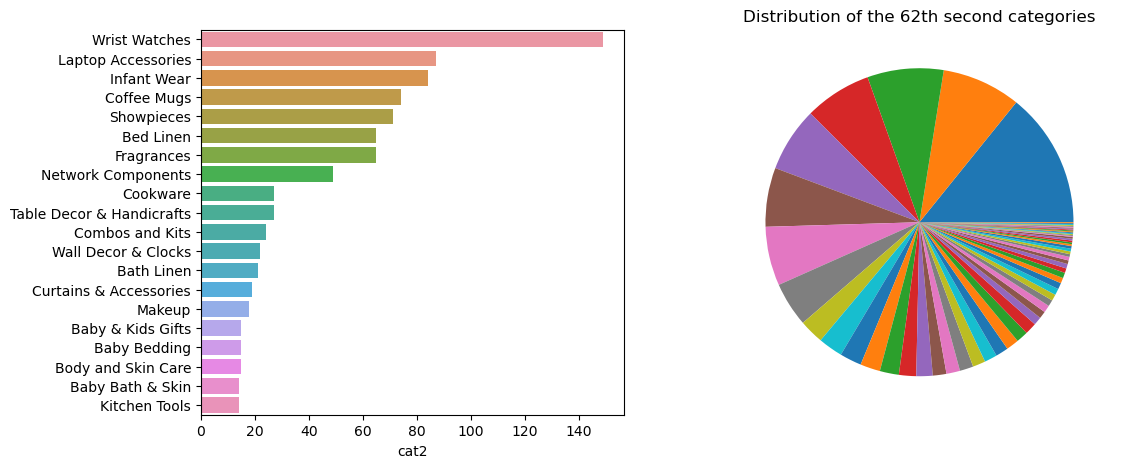

In [21]:
labels = categ_df['cat2'].value_counts().sort_values(ascending=False).index
count = categ_df['cat2'].value_counts().sort_values(ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[1].pie(count)
sns.barplot(x=count[:20], y=labels[:20], ax=axs[0])
plt.title('Distribution of the ' + str(len(labels)) + 'th second categories')

We kept the first categorie and insert it in our dataset

In [22]:
data = pd.concat([data, categ_df['cat1']], axis=1)

In [23]:
data

uniq_id  \
0     55b85ea15a1536d46b7190ad6fff8ce7   
1     7b72c92c2f6c40268628ec5f14c6d590   
2     64d5d4a258243731dc7bbb1eef49ad74   
3     d4684dcdc759dd9cdf41504698d737d8   
4     6325b6870c54cd47be6ebfbffa620ec7   
...                                ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc   
1046  fd6cbcc22efb6b761bd564c28928483c   
1047  5912e037d12774bb73a2048f35a00009   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6   
1049  f2f027ad6a6df617c9f125173da71e44   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree  \
0     ["Home Furnishing >> Curtains & Accessories >>...   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
...                                                 ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                            description             cat1  
0     Key Features of Elegance Polyester Multicolor ...  Home Furnishing  
1     Specifications of Sathiyas Cotton Bath Towel (...        Baby Care  
2     Key Features of Eurospa Cotton Terry Face Towe...        Baby Care  
3     Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing  
4     Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing  
...                                                 ...              ...  
1045  Oren Empower Extra Large Self Adhesive Sticker...        Baby Care  
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...        Baby Care  
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...        Baby Care  
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...        Baby Care  
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...        Baby Care  

[1050 rows x 6 columns]

# DESCRIPTION - Preprocessing

- CE1 Vous avez nettoyé les champs de texte (suppression de la ponctuation et des mots de liaison, mise en minuscules)
- CE2 Vous avez écrit une fonction permettant de “tokeniser” une phrase.
- CE3 Vous avez écrit une fonction permettant de “stemmer” une phrase.
- CE4 Vous avez écrit une fonction permettant de “lemmatiser” une phrase.

In [24]:
# lower and tokenizer with regexp
def tokenizer_fct(sentence):
    regexp_token = nltk.RegexpTokenizer(r'\w+')
    word_tokens = regexp_token.tokenize(sentence.lower())
    return word_tokens


# stop words english
def stop_word_filter_fct(list_words, stop_words=None):
    if stop_words is None:
        stop_words = []
    stop_w = list(set(stopwords.words('english'))) + stop_words
    filtered_w = [w for w in list_words if w not in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2


# Lemmatizer ou stemmer (base d'un mot)
def lem_stem_fct(list_words, lem=True):
    if lem:
        lemmatizer = WordNetLemmatizer()
        lem_w = [lemmatizer.lemmatize(w) for w in list_words]
        return lem_w
    else:
        stemmer = PorterStemmer()
        stem_w = [stemmer.stem(w) for w in list_words]
        return stem_w


# Fonction de préparation du texte pour le bag of words AVEC lemmatization
def transform_bow_lem_fct(desc_text, lem=True, stop_words=None):
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens, stop_words)
    lem_w = lem_stem_fct(sw, lem=lem)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text


# Fonction de préparation du texte pour le bag of words SANS lemmatization
def transform_bow_fct(desc_text, lem=True, stop_words=None):
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens, stop_words)
    # lem_w = lem_stem_fct(sw, lem=lem)
    transf_desc_text = ' '.join(sw)
    return transf_desc_text


# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(word_tokens)
    return transf_desc_text


data['sentence_bow_lem'] = data['description'] \
                                .apply(lambda x:
                                       transform_bow_lem_fct(x))
data['sentence_bow'] = data['description'] \
                                .apply(lambda x:
                                       transform_bow_fct(x))
data['sentence_dl'] = data['description'].apply(lambda x:
                                                transform_dl_fct(x))
data.shape

(1050, 9)

## Little test on first element

In [25]:
word_tokens = tokenizer_fct(data['description'][0])
sw = stop_word_filter_fct(word_tokens)
lem_stem_fct(sw, lem=True)

['key',
 'feature',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 '213',
 'height',
 'pack',
 'price',
 '899',
 'curtain',
 'enhances',
 'look',
 'interior',
 'curtain',
 'made',
 '100',
 'high',
 'quality',
 'polyester',
 'fabric',
 'feature',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring',
 'make',
 'room',
 'environment',
 'romantic',
 'loving',
 'curtain',
 'ant',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparance',
 'give',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'design',
 'surreal',
 'attention',
 'sure',
 'steal',
 'heart',
 'contemporary',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 'good',
 'morning',
 'whole',
 'world',
 'draw',
 'close',
 'evening',
 'create',
 'special',
 'moment',
 '

In [26]:
data.head(2)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                         description             cat1  \
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   

                                    sentence_bow_lem  \
0  key feature elegance polyester multicolor abst...   
1  specification sathiyas cotton bath towel bath ...   

                                        sentence_bow  \
0  key features elegance polyester multicolor abs...   
1  specifications sathiyas cotton bath towel bath...   

                                         sentence_dl  
0  key features of elegance polyester multicolor ...  
1  specifications of sathiyas cotton bath towel 3...

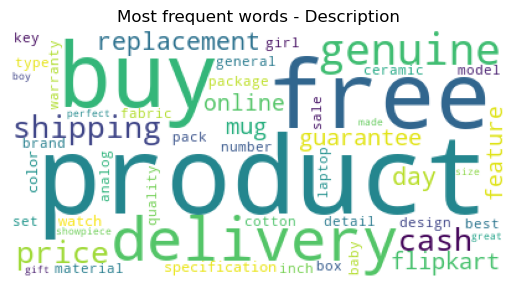

3:80: E501 line too long (86 > 79 characters)


In [27]:
wordcloud = WordCloud(background_color='white',
                      max_words=50,
                      collocations=False).generate(' '.join(data['sentence_bow_lem']))
plt.imshow(wordcloud)
plt.title('Most frequent words - Description')
plt.axis("off")
plt.show()

In [28]:
# Aggregate all the descriptions together
corpus = data['sentence_bow_lem'].str.cat(sep=' ')

# Get the list of words
list_words = corpus.split()
print("Number of words: {}".format(len(list_words)))
print("Number of unique words: {}".format(len(set(list_words))))

Number of words: 55600
Number of unique words: 5331


## Delete words  < 3 char

In [29]:
freq = pd.Series(list_words).value_counts()
freq.describe()

count    5331.000000
mean       10.429563
std        39.713444
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       864.000000
dtype: float64

In [30]:
freq.loc[freq < 3].shape

(2913,)

In [31]:
less_freq_words = freq.loc[freq < 3].index.tolist()
data['sentence_bow_lem'] = data['description'].apply(
    lambda x: transform_bow_lem_fct(x, stop_words=less_freq_words))
data['sentence_bow'] = data['description'].apply(
    lambda x: transform_bow_fct(x, stop_words=less_freq_words))

In [32]:
data.sample(10)

uniq_id  \
995  fe05e9ff9e31a310c35626ab6f2b4fe2   
532  64247967cbf6cd8bb2e243ac53aa5928   
271  9906d8f74589c452b00f2b5642a63c5f   
347  539f82930cfad8afef1a75882eb45703   
929  af13232271963742c118a1c58affa259   
632  96bc1fbb83ad5a2c0441d132fe8bcf97   
896  2eb07dc77e2fc7e3668fd7ed9b864039   
520  b64149a8a9235f5199c6d8225d5dc602   
478  a0133654f3911e47f021da4e49d42926   
782  30305ade337a4dde171afb90141bcaaa   

                                          product_name  \
995         TRESemme Naturals Vibrantly Smooth Shampoo   
532                 HMT HMTWHQ Analog Watch  - For Men   
271                S C Handicrafts Showpiece  -  40 cm   
347        Nivea Fresh Power Boost Deo Combo Combo Set   
929  Adaa Sitting Nandi with Round Base Showpiece  ...   
632        Lilliput Solid Baby Boy's Blue Cargo Shorts   
896              Rustic India Geometric Cushions Cover   
520           Maxima 29923LPGY Analog Watch  - For Men   
478     Cotonex Yellow, Green Cotton Kitchen Linen Set   
782  Perucci Pc-122 & Pc-126 Decker Analog Watch  -...   

                                 product_category_tree  \
995  ["Baby Care >> Baby Bath & Skin >> Baby Body W...   
532  ["Watches >> Wrist Watches >> HMT Wrist Watches"]   
271  ["Home Decor & Festive Needs >> Showpieces >> ...   
347  ["Beauty and Personal Care >> Fragrances >> De...   
929  ["Home Decor & Festive Needs >> Showpieces >> ...   
632  ["Baby Care >> Infant Wear >> Baby Boys' Cloth...   
896  ["Home Furnishing >> Cushions, Pillows & Cover...   
520  ["Watches >> Wrist Watches >> Maxima Wrist Wat...   
478  ["Home Furnishing >> Kitchen & Dining Linen >>...   
782  ["Watches >> Wrist Watches >> Perucci Wrist Wa...   

                                    image  \
995  fe05e9ff9e31a310c35626ab6f2b4fe2.jpg   
532  64247967cbf6cd8bb2e243ac53aa5928.jpg   
271  9906d8f74589c452b00f2b5642a63c5f.jpg   
347  539f82930cfad8afef1a75882eb45703.jpg   
929  af13232271963742c118a1c58affa259.jpg   
632  96bc1fbb83ad5a2c0441d132fe8bcf97.jpg   
896  2eb07dc77e2fc7e3668fd7ed9b864039.jpg   
520  b64149a8a9235f5199c6d8225d5dc602.jpg   
478  a0133654f3911e47f021da4e49d42926.jpg   
782  30305ade337a4dde171afb90141bcaaa.jpg   

                                           description  \
995  Key Features of TRESemme Naturals Vibrantly Sm...   
532  HMT HMTWHQ Analog Watch  - For Men - Buy HMT H...   
271  Buy S C Handicrafts Showpiece  -  40 cm for Rs...   
347  Flipkart.com: Buy Nivea Fresh Power Boost Deo ...   
929  Buy Adaa Sitting Nandi with Round Base Showpie...   
632  Key Features of Lilliput Solid Baby Boy's Blue...   
896  Rustic India Geometric Cushions Cover (Pack of...   
520  Maxima 29923LPGY Analog Watch  - For Men - Buy...   
478  Cotonex Yellow, Green Cotton Kitchen Linen Set...   
782  Perucci Pc-122 & Pc-126 Decker Analog Watch  -...   

                           cat1  \
995                   Baby Care   
532                     Watches   
271  Home Decor & Festive Needs   
347    Beauty and Personal Care   
929  Home Decor & Festive Needs   
632                   Baby Care   
896             Home Furnishing   
520                     Watches   
478             Home Furnishing   
782                     Watches   

                                      sentence_bow_lem  \
995  key feature tresemme natural vibrantly smooth ...   
532  hmt hmtwhq analog watch men buy hmt hmtwhq ana...   
271  buy handicraft showpiece online handicraft sho...   
347  flipkart com buy fresh power deo combo combo s...   
929  buy sitting round base showpiece online sittin...   
632  key feature lilliput solid baby boy blue cargo...   
896  rustic india geometric cushion cover pack blac...   
520  maximum 29923lpgy analog watch men buy maximum...   
478  cotonex yellow green cotton kitchen linen set ...   
782  perucci 122 126 decker analog watch men buy pe...   

                                          sentence_bow  \
995  key features tresemme naturals vibrantly smoot...   
532  hmt hmtwhq analog w

# DESCRIPTION - Features Extraction
## Bag of Words (Count & TF-IDF)

CE5 Vous avez construit des features ("feature engineering") de type bag-of-words (bag-of-words standard : comptage de mots, et Tf-idf), avec des étapes de nettoyage supplémentaires : seuil de fréquence des mots, normalisation des mots.

CE6 Vous avez testé une phrase ou un court texte d'exemple, pour illustrer la bonne réalisation des 5 étapes précédentes.

In [33]:
# Calcul Tsne, détermination des clusters et calcul ARI
# entre vrais catégorie et n° de clusters
def ARI_fct(features):
    time1 = time.time()
    num_labels = len(l_cat)
    tsne = manifold.TSNE(n_components=2,
                         n_iter=2000,
                         init='random',
                         random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI):
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=l_cat,
              loc="best",
              title="Categorie",
              bbox_to_anchor=(0, 1))
    plt.title('Représentation des descriptions par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=set(labels),
              loc="best",
              title="Clusters",
              bbox_to_anchor=(0, 1))
    plt.title('Représentation des descriptions par clusters')

    plt.show()
    print("ARI : ", ARI)

In [34]:
# création du bag of words (CountVectorizer et Tf-idf)

l_cat = list(set(data['cat1']))
print("catégories : ", l_cat)
y_cat_num = [(l_cat.index(data.iloc[i]['cat1'])) for i in range(len(data))]

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'

cv_transform = cvect.fit_transform(data[feat])
ctf_transform = ctf.fit_transform(data[feat])

catégories :  ['Home Decor & Festive Needs', 'Beauty and Personal Care', 'Computers', 'Baby Care', 'Home Furnishing', 'Watches', 'Kitchen & Dining']


In [35]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)

print()

print("Tf-idf : ")
print("--------")
ARI_tf, X_tsne_tf, labels_tf = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------
ARI :  0.4095 time :  8.0

Tf-idf : 
--------
ARI :  0.4965 time :  7.0


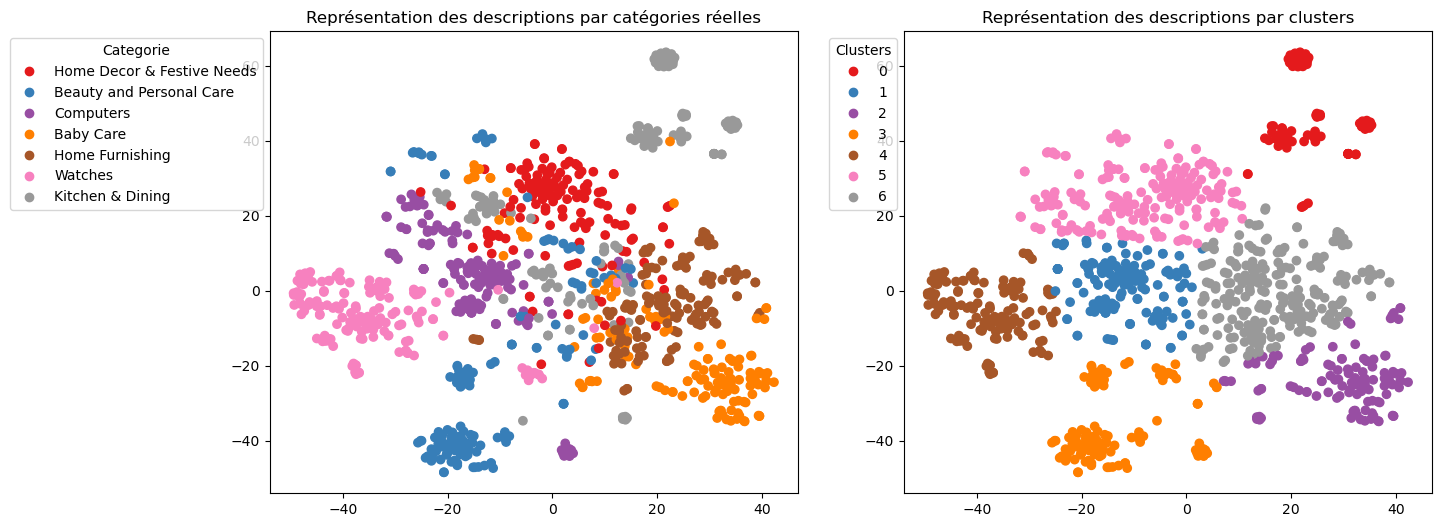

ARI :  0.4095


In [36]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

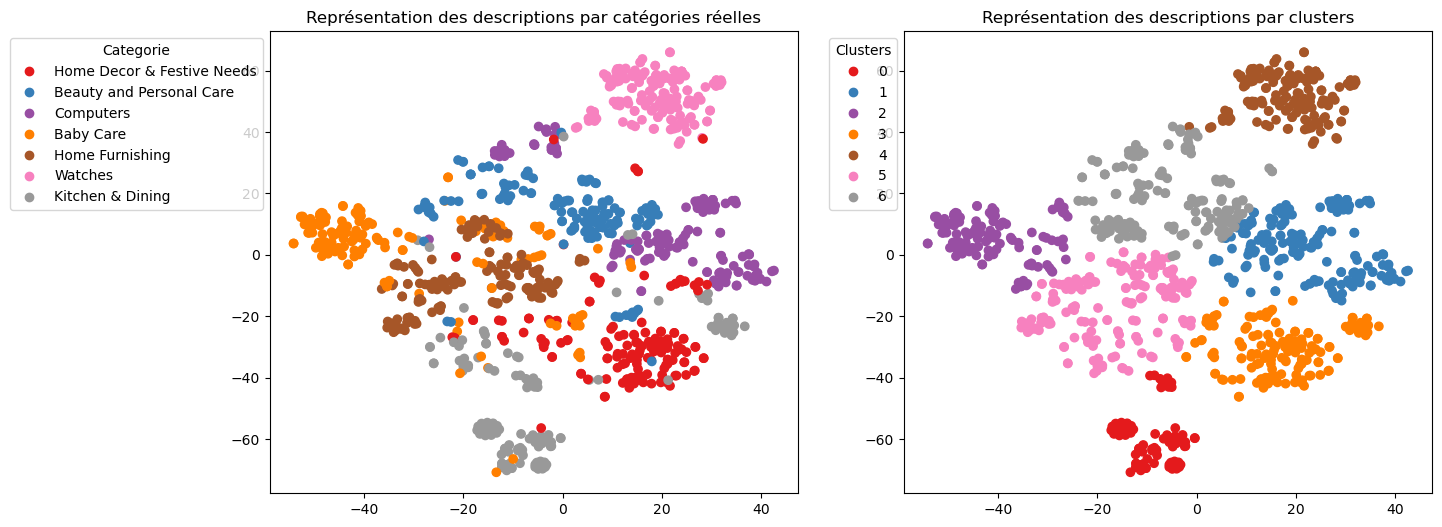

ARI :  0.4965


In [37]:
TSNE_visu_fct(X_tsne_tf, y_cat_num, labels_tf, ARI_tf)

## Word2Vec

CE7 Vous avez, en complément de la démarche de type “bag-of-words”, mis en oeuvre 3 démarches de word/sentence embedding : Word2Vec (ou Doc2Vec ou Glove ou FastText), BERT, et USE (Universal Sentence Encoder).

CE8 Vous vous êtes assurés que le texte traité ne relève pas d’une propriété intellectuelle dont l’utilisation ou la modification est interdite.

In [38]:
w2v_size = 300
w2v_window = 10
w2v_min_count = 1
w2v_epochs = 100
maxlen = 300  # adapt to length of sentences
sentences = data['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [39]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count,
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=1)

w2v_model.build_vocab(sentences)
w2v_model.train(sentences,
                total_examples=w2v_model.corpus_count,
                epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 2377
Word2Vec trained


In [40]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 2378


In [41]:
x_sentences.shape

(1050, 300)

### Création de la matrice d'embedding

In [42]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (2378, 300)


### Création du modèle d'embedding

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
# Création du modèle

word_input = Input(shape=(maxlen, ), dtype='float64')
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
wv_model = Model([word_input], word_vec)

wv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          713400    
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 713,400
Trainable params: 713,400
Non-trainable params: 0
_________________________________________________________________


### Exécution du modèle

In [44]:
features_wv = wv_model.predict(x_sentences)
features_wv.shape

33/33 [==============================] - 0s 832us/step


(1050, 300)

In [45]:
ARI, X_tsne, labels = ARI_fct(features_wv)

ARI :  0.4134 time :  7.0


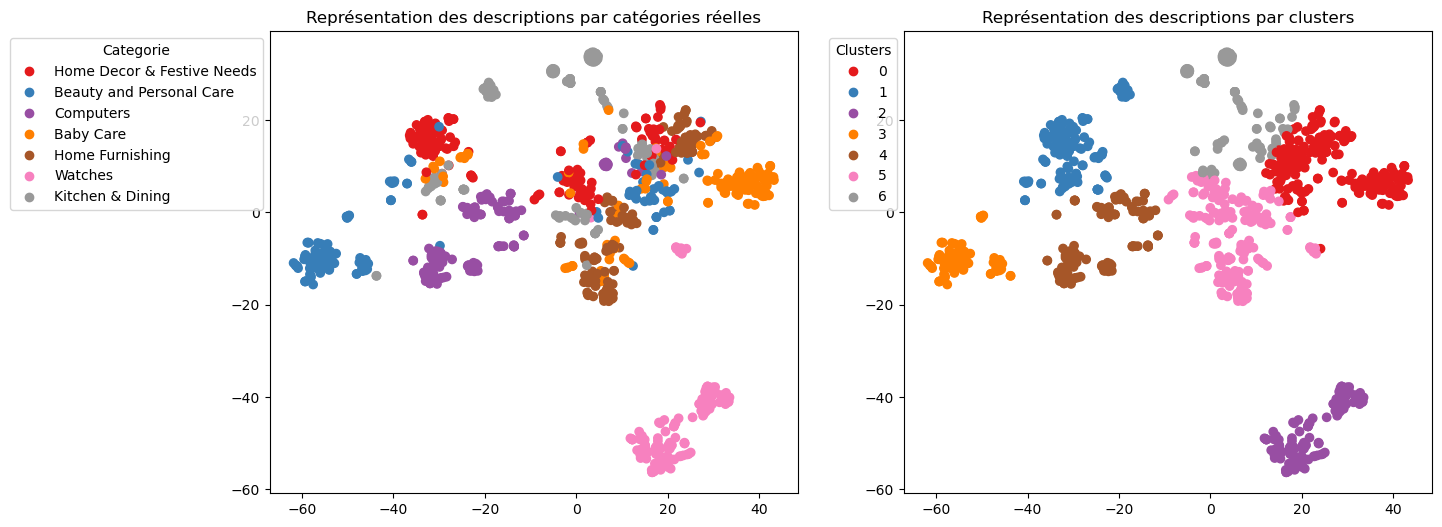

ARI :  0.4134


In [46]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT

In [47]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model,
                     model_type,
                     sentences,
                     max_length,
                     b_size,
                     mode='HF'):
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step * batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot =\
            bert_inp_fct(sentences[idx:idx+batch_size],
                         bert_tokenizer,
                         max_length)

        if mode == 'HF':    # Bert HuggingFace
            outputs = model.predict([input_ids,
                                     attention_mask,
                                     token_type_ids],
                                    batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids": input_ids,
                                 "input_mask": attention_mask,
                                 "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,
                                                     last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

In [48]:
max_length = 32
batch_size = 10
model_type = 'bert-large-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data['sentence_dl'].to_list()

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [49]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model,
                                                         model_type,
                                                         sentences,
                                                         max_length,
                                                         batch_size,
                                                         mode='HF')

1/1 [==============================] - 1s 838ms/step
temps traitement :  101.0


In [50]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.4808 time :  7.0


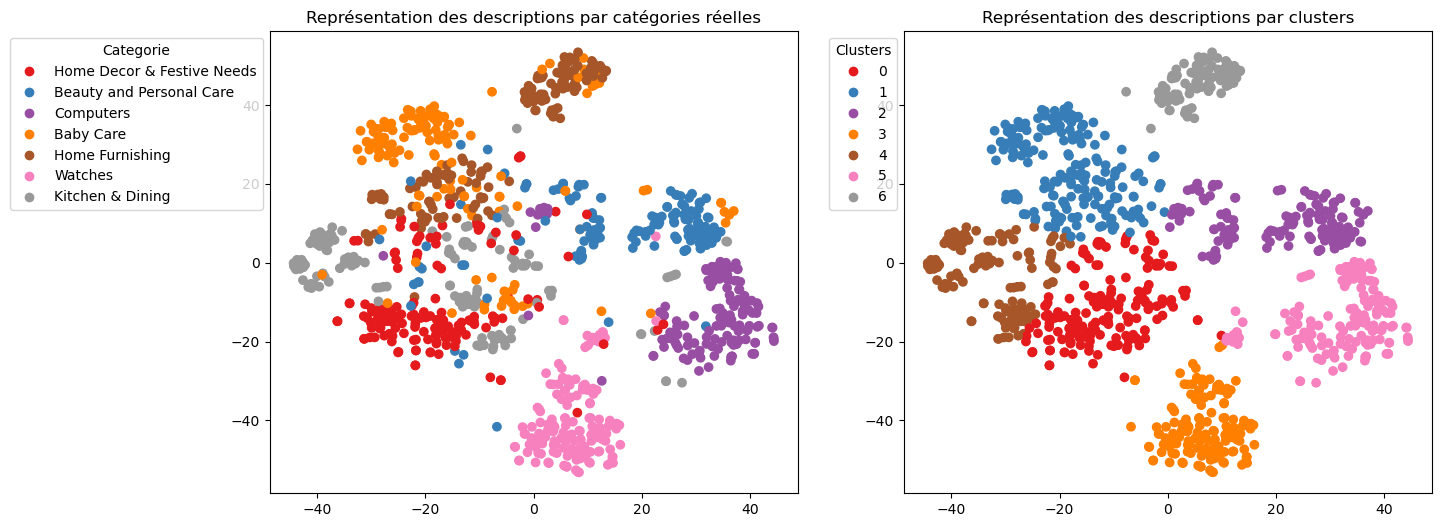

ARI :  0.4808


In [51]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## USE - Universal Sentence Encoder

In [52]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [53]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step * batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)
    return features

In [54]:
batch_size = 10
sentences = data['sentence_dl'].to_list()

In [55]:
features_USE = feature_USE_fct(sentences, batch_size)

temps traitement :  1.0


In [56]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.4236 time :  7.0


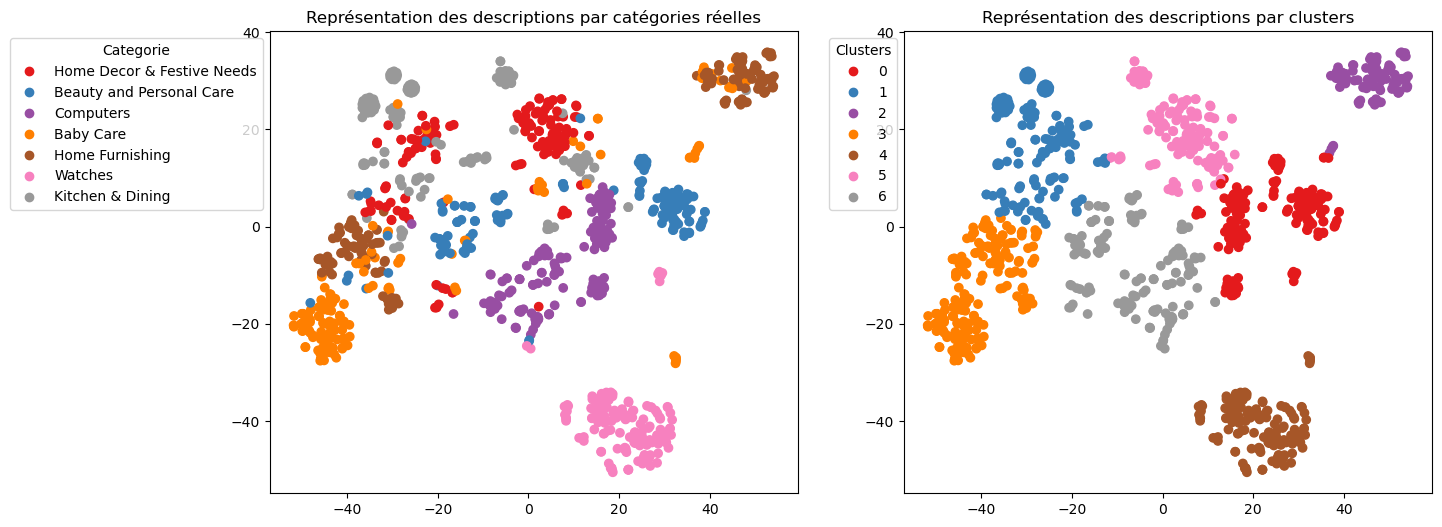

ARI :  0.4236


In [57]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# IMAGE - Exploration

In [58]:
data.groupby("cat1").count()

uniq_id  product_name  product_category_tree  \
cat1                                                                       
Baby Care                       150           150                    150   
Beauty and Personal Care        150           150                    150   
Computers                       150           150                    150   
Home Decor & Festive Needs      150           150                    150   
Home Furnishing                 150           150                    150   
Kitchen & Dining                150           150                    150   
Watches                         150           150                    150   

                            image  description  sentence_bow_lem  \
cat1                                                               
Baby Care                     150          150               150   
Beauty and Personal Care      150          150               150   
Computers                     150          150               150   
Home Decor & Festive Needs    150          150               150   
Home Furnishing               150          150               150   
Kitchen & Dining              150          150               150   
Watches                       150          150               150   

                            sentence_bow  sentence_dl  
cat1                                                   
Baby Care                            150          150  
Beauty and Personal Care             150          150  
Computers                            150          150  
Home Decor & Festive Needs           150          150  
Home Furnishing                      150          150  
Kitchen & Dining                     150          150  
Watches                              150          150

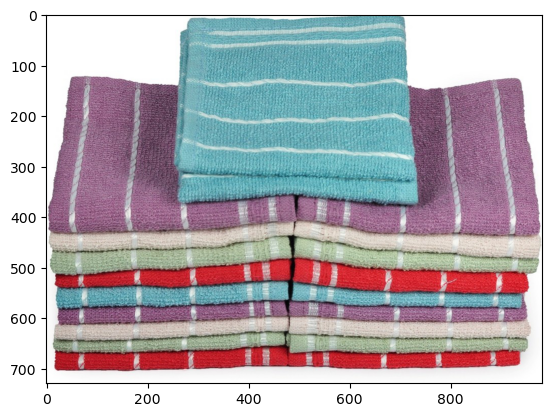

In [59]:
# Chemin absolu du répertoire courant
current_dir = os.getcwd()
folder = current_dir + '\\Flipkart\\Images\\'

for i, file in enumerate(data['image']):
    data.loc[i, 'img_path'] = folder + file

image = imread(data['img_path'][2])
plt.imshow(image)

Home Furnishing


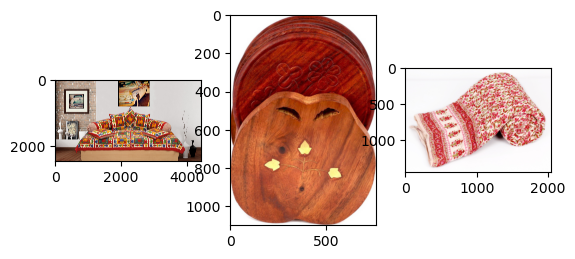

Baby Care


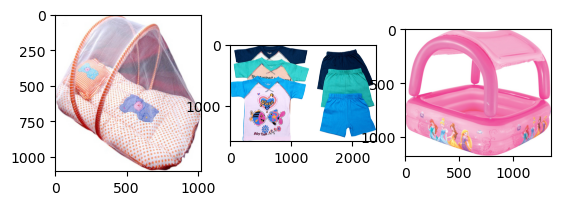

Watches


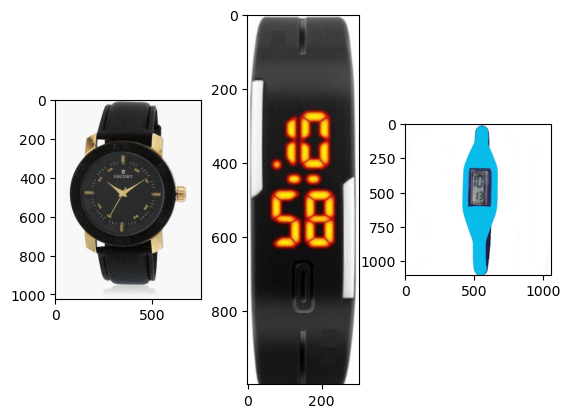

Home Decor & Festive Needs


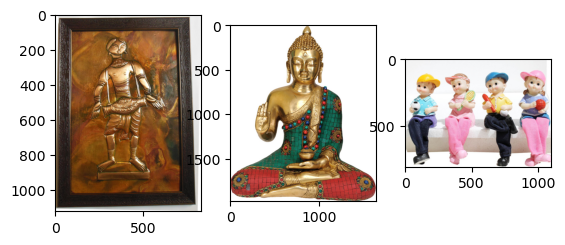

Kitchen & Dining


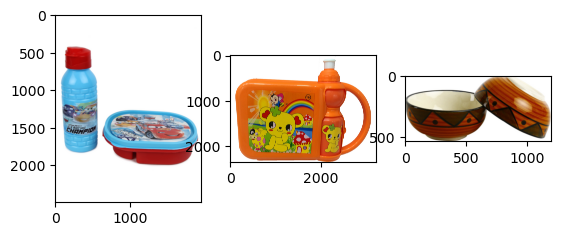

Beauty and Personal Care


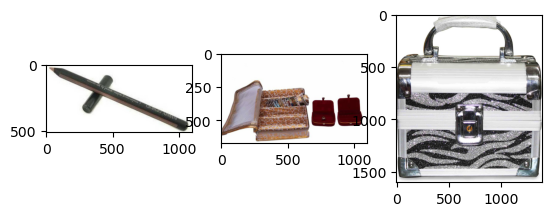

Computers


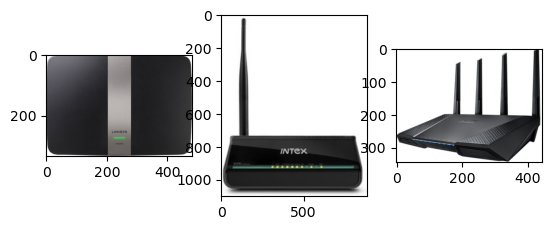

In [60]:
list_labels = data['cat1'].unique()


def list_fct(name):
    list_image_name = [data["img_path"][i]
                       for i in range(len(data))
                       if data["cat1"][i] == name]
    return list_image_name


for name in list_labels:
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# IMAGE - Features Extraction

## SIFT

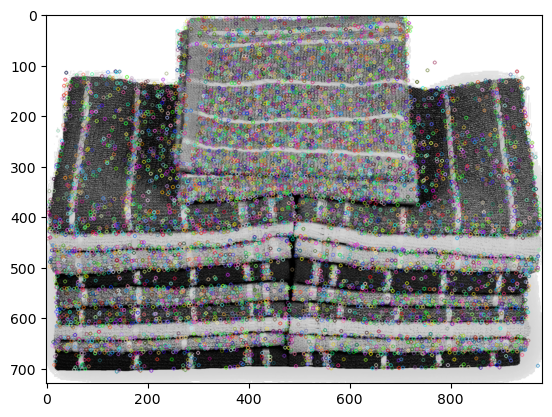

Descripteurs :  (8896, 128)

[[117.  56.   1. ...   1.   2.   0.]
 [ 30.   2.  15. ...   1.   2.   1.]
 [ 14.  19.   9. ...   1.   1.   1.]
 ...
 [ 57. 127.   9. ...   1.   1.   4.]
 [ 16.   7.   6. ...   0.   0.   0.]
 [ 26.   8.  11. ...   0.   0.   0.]]


In [61]:
sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(data['img_path'][2], 0)  # convert in gray
image = cv2.equalizeHist(image)  # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

In [62]:
def create_descriptors(images_path, size=500):
    sift_keypoints = []
    temps1 = time.time()
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=size)

    for i in range(len(images_path)):
        if i % 100 == 0:
            print(i)
        image = cv2.imread(images_path[i], 0)  # convert in gray
        res = cv2.equalizeHist(image)  # equalize image histogram
        kp, des = sift.detectAndCompute(res, None)
        sift_keypoints.append(des)

    sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)
    print()
    print("Nombre de descripteurs : ", sift_keypoints_all.shape)

    duration1 = time.time() - temps1
    print("temps de traitement SIFT descriptor : ",
          "%15.2f" % duration1,
          "secondes")

    return sift_keypoints_all, sift_keypoints

In [63]:
sift_keypoints_all, sift_keypoints = create_descriptors(data['img_path'])

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           316.66 secondes


## Création des clusters de descripteurs (BOVW)
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [64]:
# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k,
                                 n_init='auto',
                                 init_size=3 * k,
                                 random_state=0)
kmeans.fit(sift_keypoints_all)

duration1 = time.time() - temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :             2.58 secondes


## Création des features des images (histogramme)
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [65]:
# Creation of histograms (features)
temps1 = time.time()


def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints):
    if i % 100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            26.84 secondes


In [84]:
im_features.shape

(1050, 719)

## Réductions de dimension

### Réduction de dimension PCA

In [66]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 500)


### Réduction de dimension T-SNE

In [67]:
tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["cat1"]
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

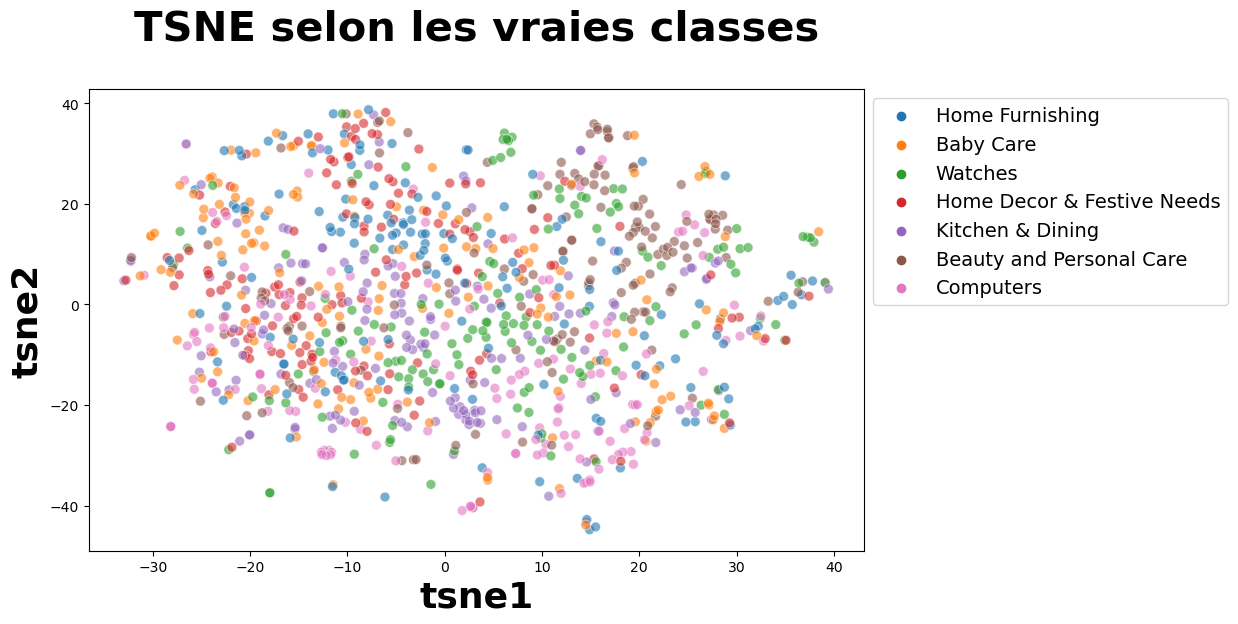

In [68]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="tsne1", y="tsne2",
                hue="class", data=df_tsne,
                legend="brief",
                s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes',
          fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14}, bbox_to_anchor=(1, 1))

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [69]:
cls = cluster.KMeans(n_clusters=len(l_cat), n_init='auto', random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

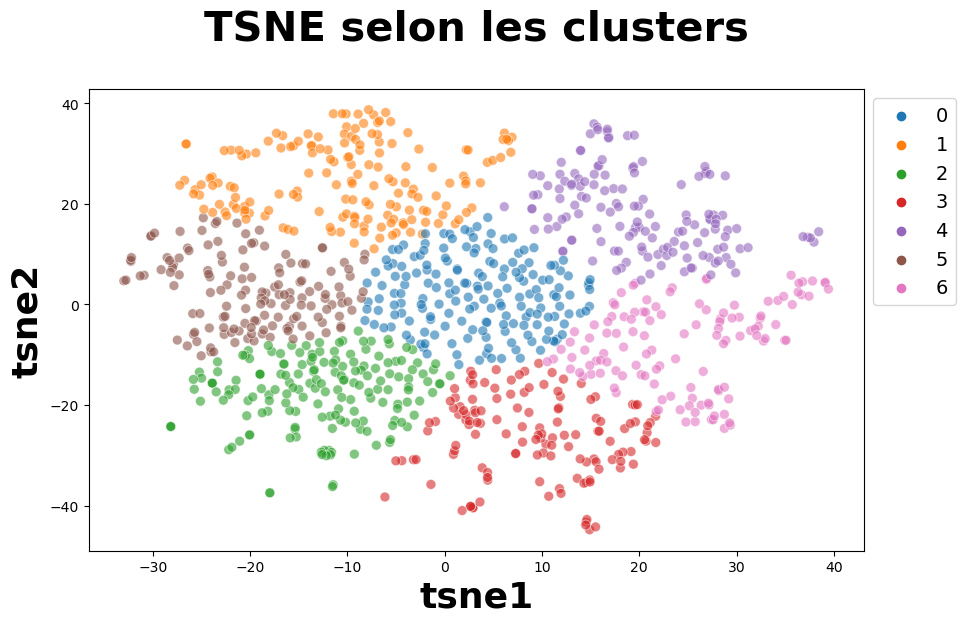

ARI :  0.05991424523138243


In [70]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=len(l_cat)), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14}, bbox_to_anchor=(1, 1))

plt.show()

labels = df_tsne["class"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes

In [71]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    175
1    166
2    169
3    132
4    142
5    143
6    123
Name: class, dtype: int64

<Axes: >

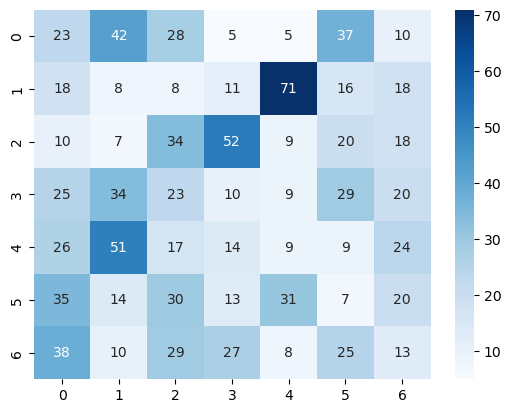

In [72]:
conf_mat = metrics.confusion_matrix(y_cat_num, cls.labels_)

sns.heatmap(conf_mat, annot=True, cmap="Blues")

## CNN - Transfer Learning

### Création du modèle pré-entraîné

In [73]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Création des features des images

In [74]:
images_features = []
i = 0
for image_file in data['img_path']:
    if i % 100 == 0:
        print(i)
    i += 1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0])

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


C:\Users\octav\anaconda3\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

### Réduction dimension et analyse

### Réduction de dimension PCA

In [75]:
print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [76]:
temps1 = time.time()

tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=2000,
                     init='random',
                     random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1 = time.time() - temps1
print("temps T-SNE : ", "%15.2f" % duration1, "secondes")

temps T-SNE :             4.66 secondes


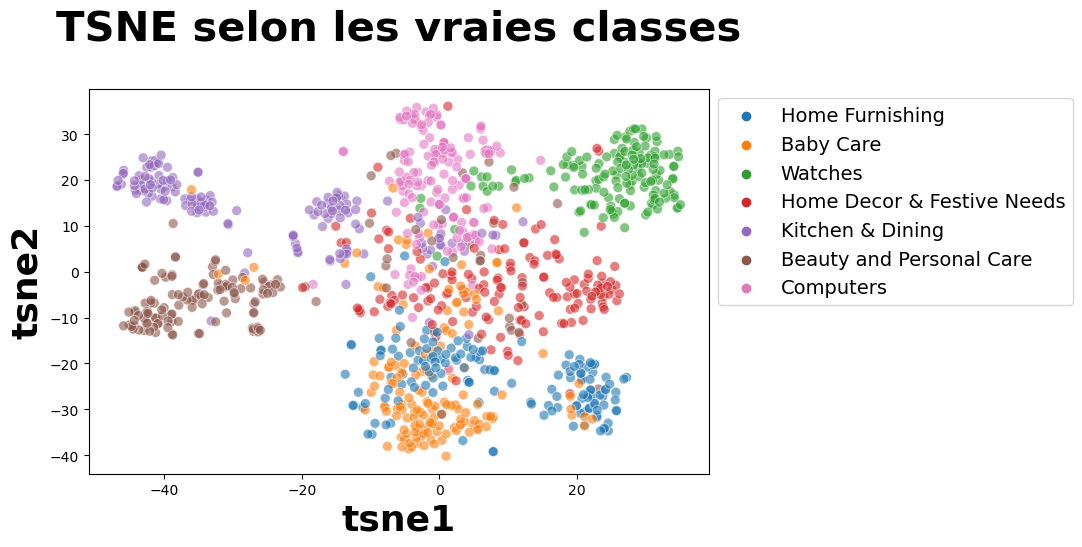

In [77]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["cat1"]

plt.figure(figsize=(8, 5))
sns.scatterplot(x="tsne1", y="tsne2",
                hue="class",
                palette=sns.color_palette('tab10', n_colors=7),
                s=50, alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les vraies classes',
          fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14}, bbox_to_anchor=(1, 1))

plt.show()

* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement


In [78]:
cls = cluster.KMeans(n_clusters=7, n_init='auto')
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init='auto')

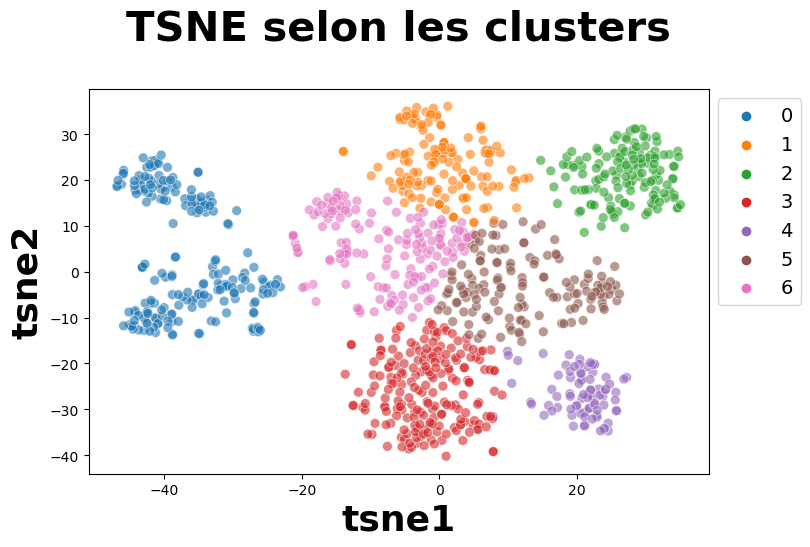

ARI :  0.4777023343799811


In [79]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8, 5))
sns.scatterplot(x="tsne1", y="tsne2",
                hue="cluster",
                palette=sns.color_palette('tab10', n_colors=7),
                s=50, alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les clusters',
          fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14}, bbox_to_anchor=(1, 1))

plt.show()

labels = data["cat1"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes

In [80]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']

In [81]:
cls_labels_transform = conf_mat_transform(y_cat_num, cls.labels_)
conf_mat = metrics.confusion_matrix(y_cat_num, cls_labels_transform)
print(metrics.classification_report(y_cat_num, cls_labels_transform))

Correspondance des clusters :  [1 2 5 3 4 0 6]
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       150
           1       0.58      0.77      0.66       150
           2       0.80      0.75      0.77       150
           3       0.56      0.74      0.63       150
           4       0.84      0.44      0.58       150
           5       0.96      0.89      0.92       150
           6       0.41      0.41      0.41       150

    accuracy                           0.67      1050
   macro avg       0.70      0.67      0.67      1050
weighted avg       0.70      0.67      0.67      1050



<Axes: >

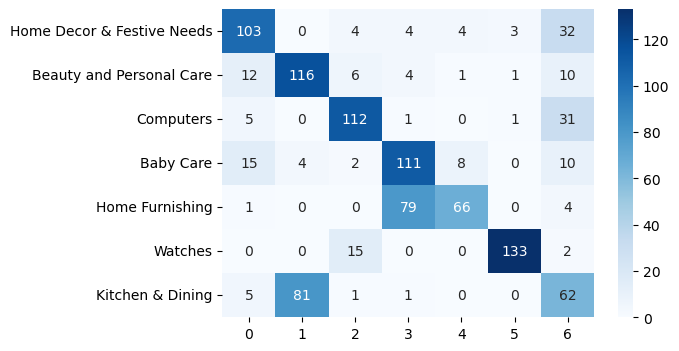

In [82]:
df_cm = pd.DataFrame(conf_mat, index=l_cat)
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

# Sauvegarde du dataset

In [83]:
data.to_csv('data_cleaned.csv', index=False)